+ 运行流程
    1. 损失函数定义为：$ \frac{-1}{N}\sum {[y*log(data)+(1-y)*log(1-data)]}$
    2. 第一步，更新判别网络，需要最小化loss，目的是为了使得$ \frac{-1}{N}\sum {[log(data)+log(1-data)]}$最小，直白的解释就是：当数据是真实时，使得$log(data)$尽可能地大；当数据为假时，使得$log(1-data)$尽可能大，data表示数据为真的概率。
    3. 第二部，更新生成网络，需要最小化loss,目的是为了使得$ \frac{-1}{N}\sum {[log(data)]}$
+ 理论推导
1. 直观理解：最大化似然估计等价于最小化KL-Divergence，[Prove](https://wiseodd.github.io/techblog/2017/01/26/kl-mle/)
其中一个关键性推导:<br>
$假设我们从真实数据P_{data}中sample出N笔数据，根据大数定理，当N趋向无穷大时:$
$$-\frac{1}{N} \sum_i^N \log \, P(x_i \vert \theta) = -\mathbb{E}_{x \sim P(x \vert \theta^*)}\left[\log \, P(x \vert \theta) \right]$$
注意到：
$$-\frac{1}{N} \sum_i^N \log \, P(x_i \vert \theta)$$
$$ = \frac{1}{N} \, \text{NLL}= c \, \text{NLL}$$

In [7]:
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision

In [2]:
def imshow(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    npimgs = imgs.detach().numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [5]:
data_loader = data.DataLoader(
    dataset=datasets.MNIST(
        root='./data',
        transform=transforms.ToTensor(),
        download=False),
    shuffle=True,
    batch_size = 64
)

In [18]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(100,256),
            nn.ReLU(),
            nn.Linear(256,28*28),
            nn.Sigmoid()
        )
    
    def forward(self,x):
        insize = x.size(0)
        output = self.layer(x)
        return output
    
class Disriminator(nn.Module):
    def __init__(self):
        super(Disriminator,self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(28*28,128),
            nn.ReLU(),
            nn.Linear(128,1),
            nn.Sigmoid() # 概率值
        )
    
    def forward(self,x):
        output = self.layer(x)
        return output

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

gen = Generator()
dis = Disriminator()

optim_g = torch.optim.Adam(gen.parameters())
optim_d = torch.optim.Adam(dis.parameters())  

In [25]:
gen.to(device)
dis.to(device)

for epoch in range(50):
    g_loss_sum = 0.0
    d_loss_sum = 0.0
    for step,(x_data,y_data) in enumerate(data_loader):
        x_data = x_data.to(device)
        size = x_data.size()
        
        ones_labels = torch.ones(size[0],1).to(device)
        zero_labels = torch.zeros(size[0],1).to(device)
        z = torch.randn(size[0],100).to(device)
        
        x_data = x_data.view(size[0],-1).to(device)
        
        loss_real = F.binary_cross_entropy(dis(x_data),ones_labels)
        loss_fake = F.binary_cross_entropy(dis(gen(z)),zero_labels)
        loss_d = loss_real + loss_fake
        
        optim_d.zero_grad()
        loss_d.backward()
        optim_d.step()
        
        z = torch.randn(size[0],100).to(device)
        loss_g = F.binary_cross_entropy(dis(gen(z)),ones_labels)
        optim_g.zero_grad()
        loss_g.backward()
        optim_g.step()
        
        g_loss_sum += loss_g.item()
        d_loss_sum += loss_d.item()
    
    print("Epoch %d G Loss %.3f, D Loss %.3f" % (epoch, g_loss_sum / step,d_loss_sum / step))
    
        
        

G Loss 4.620, D Loss 0.185
G Loss 5.006, D Loss 0.069
G Loss 4.946, D Loss 0.116


KeyboardInterrupt: 

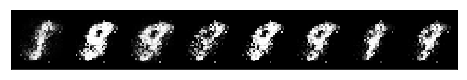

In [58]:
imgs = gen(torch.rand(8,100)).view(8,1,28,28)
imshow(imgs[:8])